In [77]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
class CONFIG():
    dataset_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset"
    train_csv_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/train.csv"
    train_folder_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/train_images"
    test_folder_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/test_images"
    submission_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/sample_submission.csv"

    classes = ['complex','frog_eye_leaf_spot','powdery_mildew', 
                'rust','scab','healthy']

    strategy = tf.distribute.get_strategy()
    batch_size = 16

    random_seed = 42
    img_size = 512
    folds = 5
    subfolds = 16 # tfrecords per one fold

In [20]:
train_csv = pd.read_csv(CONFIG.train_csv_path)

In [29]:
# label
from sklearn.preprocessing import MultiLabelBinarizer
image_names = train_csv['image']

labels =  [x.split(' ') for x in train_csv['labels']]
labels = MultiLabelBinarizer(classes=CONFIG.classes).fit_transform(labels)

train_binarized = pd.DataFrame(columns=CFG.classes, data=labels, index=image_names)
train_binarized.to_csv("/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Dataset/train_binarized.csv")
train_binarized

,complex,frog_eye_leaf_spot,powdery_mildew,rust,scab,healthy
image,,,,,,
800113bb65efe69e.jpg,0,0,0,0,0,1
8002cb321f8bfcdf.jpg,1,1,0,0,1,0
80070f7fb5e2ccaa.jpg,0,0,0,0,1,0
80077517781fb94f.jpg,0,0,0,0,1,0
800cbf0ff87721f8.jpg,1,0,0,0,0,0
...,...,...,...,...,...,...
fffb900a92289a33.jpg,0,0,0,0,0,1
fffc488fa4c0e80c.jpg,0,0,0,0,1,0
fffc94e092a59086.jpg,0,0,0,1,0,0


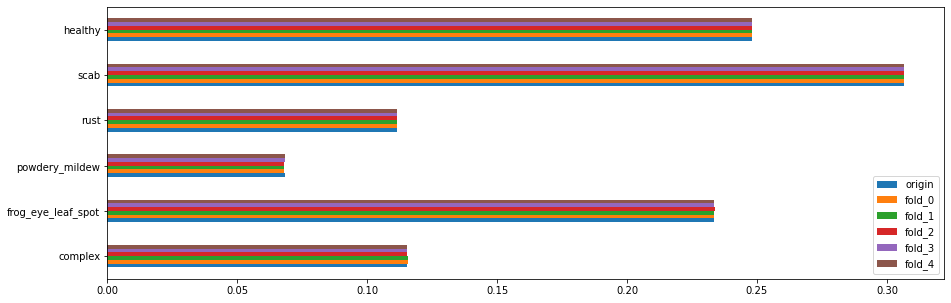

In [44]:
# folding
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.random_seed)
fold = np.zeros((len(train_binarized),))

for i, (train_index, val_index) in enumerate(kfold.split(image_names, train_csv['labels'])):
    fold[val_index] = i

value_counts = lambda x: pd.Series.value_counts(x, normalize=True)

df_occurence = pd.DataFrame({
    'origin': train_binarized.apply(value_counts).loc[1],
    'fold_0': train_binarized[fold == 0].apply(value_counts).loc[1],
    'fold_1': train_binarized[fold == 1].apply(value_counts).loc[1],
    'fold_2': train_binarized[fold == 2].apply(value_counts).loc[1],
    'fold_3': train_binarized[fold == 3].apply(value_counts).loc[1],
    'fold_4': train_binarized[fold == 4].apply(value_counts).loc[1]})

bar = df_occurence.plot.barh(figsize=[15, 5])

In [69]:
len(train_binarized[fold == 4])

3726

In [80]:
def serialize_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [CONFIG.img_size, CONFIG.img_size])
    image = tf.cast(image, tf.uint8)
        
    return tf.image.encode_jpeg(image).numpy()


def serialize_sample(image, image_name, label):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'image_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_name])),
        'complex': tf.train.Feature(int64_list=tf.train.Int64List(value=[label[0]])),
        'frog_eye_leaf_spot': tf.train.Feature(int64_list=tf.train.Int64List(value=[label[1]])),
        'powdery_mildew': tf.train.Feature(int64_list=tf.train.Int64List(value=[label[2]])),
        'rust': tf.train.Feature(int64_list=tf.train.Int64List(value=[label[3]])),
        'scab': tf.train.Feature(int64_list=tf.train.Int64List(value=[label[4]])),
        'healthy': tf.train.Feature(int64_list=tf.train.Int64List(value=[label[5]]))}
    sample = tf.train.Example(features=tf.train.Features(feature=feature))
    return sample.SerializeToString()


def serialize_fold(fold, name, bar=None):
    samples = []
    
    for image_name, labels in fold.iterrows():
        path = os.path.join(CONFIG.train_folder_path, image_name)
        image = serialize_image(path)
        serialized_sample = serialize_sample(image, image_name.encode(), labels)
        samples.append(serialized_sample)
    
    with tf.io.TFRecordWriter(name + '.tfrec') as writer:
        [writer.write(x) for x in samples]
        
    if bar is not None:
        bar.update(1)


# serialize_image(f"{CONFIG.train_folder_path}/800113bb65efe69e.jpg")

In [81]:
total = CONFIG.folds * CONFIG.subfolds

with tqdm(total=total) as bar:

    for i in range(CONFIG.folds):

        df_fold = train_binarized[fold == i]
        folder = f'{CONFIG.dataset_path}/TFRecords/fold_{i}'
        
        try:
            os.mkdir(folder)
        except FileExistsError:
            shutil.rmtree(folder)
            os.mkdir(folder)

        for k, subfold in enumerate(np.array_split(df_fold, CONFIG.subfolds)):
            name=os.path.join(folder, '%.2i-%.3i' % (k, len(subfold)))
            serialize_fold(subfold, name=name, bar=bar)

In [95]:
## Test

feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'complex': tf.io.FixedLenFeature([], tf.int64),
    'frog_eye_leaf_spot': tf.io.FixedLenFeature([], tf.int64),
    'powdery_mildew': tf.io.FixedLenFeature([], tf.int64),
    'rust': tf.io.FixedLenFeature([], tf.int64),
    'scab': tf.io.FixedLenFeature([], tf.int64),
    'healthy': tf.io.FixedLenFeature([], tf.int64)}


def count_data_items(filenames):
    return np.sum([int(x[:-6].split('-')[-1]) for x in filenames])


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.reshape(image, [CONFIG.img_size, CONFIG.img_size, 3])
    image = tf.cast(image, tf.float32) / 255.
    return image


def read_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_map)
    image = decode_image(example['image'])
    target = [
        tf.cast(example['complex'], tf.float32),
        tf.cast(example['frog_eye_leaf_spot'], tf.float32),
        tf.cast(example['healthy'], tf.float32),
        tf.cast(example['powdery_mildew'], tf.float32),
        tf.cast(example['rust'], tf.float32),
        tf.cast(example['scab'], tf.float32)]
    return image, target


def get_dataset(filenames):
    auto = tf.data.experimental.AUTOTUNE
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=auto)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=auto)
    dataset = dataset.batch(CONFIG.batch_size)
    dataset = dataset.prefetch(auto)
    return CONFIG.strategy.experimental_distribute_dataset(dataset)


def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.applications.EfficientNetB0(
            include_top=False,
            input_shape=(CONFIG.img_size, CONFIG.img_size, 3),
            weights=None,
            pooling='avg'),
        tf.keras.layers.Dense(len(feature_map) - 2),
        tf.keras.layers.Activation('sigmoid', dtype='float32')
    ], name='EfficientNetB0')
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [87]:
filenames = tf.io.gfile.glob(f'{CONFIG.dataset_path}/TFRecords/fold_0/*.tfrec')[:1]
dataset = get_dataset(filenames)

In [97]:
steps_per_epoch = count_data_items(filenames) // CONFIG.batch_size

with CONFIG.strategy.scope():
    model = get_model()

# model.summary()

history = model.fit(
    dataset, 
    steps_per_epoch=steps_per_epoch,
    epochs=1)

14/14 [==============================] - 315s 22s/step - loss: 2.0359 - accuracy: 0.2240
